In [31]:
# Import required packages
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import support_functions 

# Challenge: Predicting COVID-19 from chest CT scans

# Load data

We first load the provided training images from folders. Loading is taken care of by `read_ct_scan` function.

In [12]:
# Get public covid, noncovid and normal images
base_path = os.path.join(os.getcwd(), '..', 'data', 'Images-processed')

noncovid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_NonCOVID'))
covid_images = support_functions.read_ct_scan(os.path.join(base_path, 'CT_COVID'))

print('Total number of images: ')
print('Covid: ', len(noncovid_images))
print('Noncovid: ', len(covid_images))

Total number of images: 
Covid:  292
Noncovid:  251


Let's have a look at some noncovid and covid CT scans.

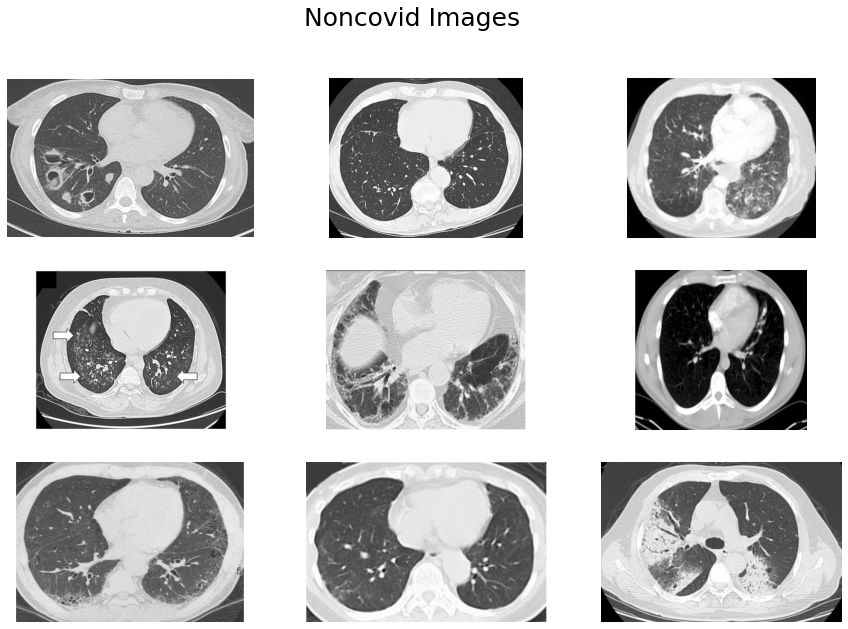

In [29]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(noncovid_images[i]/255.)
    plt.axis("off")
plt.suptitle('Noncovid Images', fontsize=25);

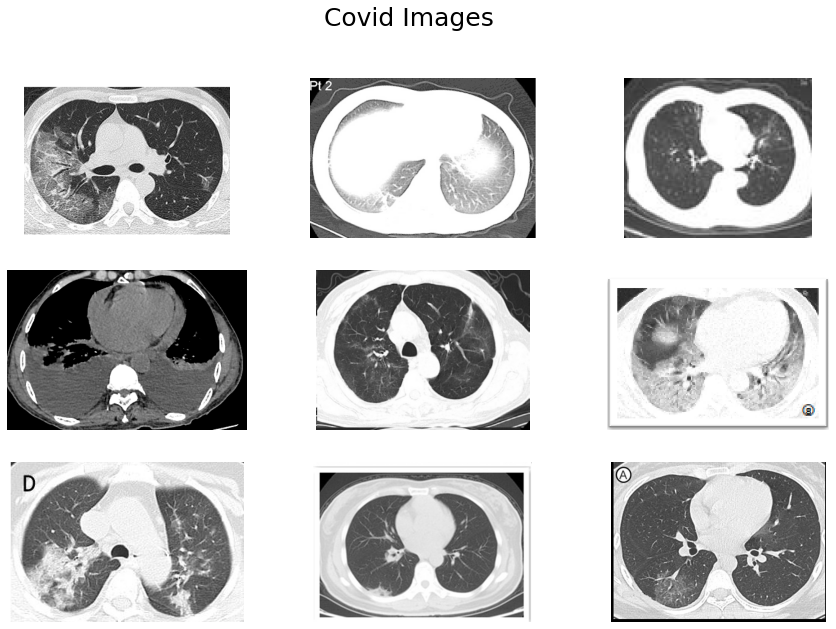

In [30]:
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(covid_images[i]/255.)
    plt.axis("off")
plt.suptitle('Covid Images', fontsize=25);

# Set up data for training

Let's create binary training labels for our covid and noncovid images, that is

- Noncovid: 0
- Covid: 1

The labels are required for our supervised classification task.

In [14]:
noncovid_labels = np.full(len(noncovid_images),fill_value=0)
covid_labels = np.full(len(covid_images),fill_value=1)

## Train-validation split

Here we reserve 20% of the data for validation. 

Note that, since some consecutive images may come from the same patient, they tend to be similar to each other. That is, our data is **not independent**. To prevent data leakage (information of training data spills over to validation data), we keep the original image sequence and hold out the last 20% as the validation set. 

After the splitting, we have two pairs of data:
1. `X_train`, `y_train`
2. `X_val`, `y_val`

X is a list of CT scans, and y is a list of binary labels.

In [40]:
# Train-validation split while keeping the order of the images
train_data_portion = 0.8 # Proportion of data for training

# Get integer number of training samples
train_covid_size = round(len(covid_images)*train_data_portion)
train_noncovid_size = round(len(noncovid_images)*train_data_portion)

# Split the dataset in its original sequence
X_train = noncovid_images[:train_noncovid_size] + covid_images[:train_covid_size]
y_train = np.concatenate((noncovid_labels[:train_noncovid_size], 
                          covid_labels[:train_covid_size]))

X_val = noncovid_images[train_noncovid_size:] + covid_images[train_covid_size:]
y_val = np.concatenate((noncovid_labels[train_noncovid_size:], 
                        covid_labels[train_covid_size:]))

print('Train-validation split:')
print('{} training images and {} validation images'.format(len(X_train), len(X_val)))

Train-validation split:
435 training images and 108 validation images


## Create `tf.data.Dataset` object

We create two `tf.data.Dataset` objects, one for training and the other for validation. 

The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. Essentially, it is a tensorflow data structure that greatly simplifies some essential operations, for example, preporcessing, shuffling and training. You can read more about it [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

In the `resize_and_shuffle` function, we 
1. create a `Dataset` object from a (`X, y`) pair,
2. resize each image to a standard size,
3. shuffle and split the data into batches for training later.

In [43]:
# Define global variables
IMG_SIZE = (256,256) # Standardize all images to this size
BATCH_SIZE = 32 # Number of training images for each gradient update
RANDOM_SEED = 123 # Random seed to ensure reproducibility

# Create training and validation Dataset objects
train_ds = support_functions.resize_and_shuffle(X_train, y_train, img_size=IMG_SIZE)
val_ds = support_functions.resize_and_shuffle(X_val, y_val, img_size=IMG_SIZE)

Since we have 435 training images, with a batch size of 32, we expect to get 14 batches of data. You can verify this by running the next cell.

In [52]:
train_ds.cardinality().numpy()

14

## Data augmentation

Here we use `tf.keras.Sequential` to create a pipeline in which the input image is randomly transformed through the following operations:
1. Random horizontal and vertical flip
2. Rotation by a random degree in [-5%, 5%]*2$\pi$
3. Random zoom in height by 5%
4. Random translation by 5%
5. Random contrast adjustment by 5%

In [60]:
# Create data agumentation layer
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomRotation((-0.05, 0.05), seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomZoom(-0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, seed=RANDOM_SEED),
        layers.experimental.preprocessing.RandomContrast(0.05, seed=RANDOM_SEED),
    ]
)

In [58]:
# Augment training data using augmentation layer
augmented_train_ds = train_ds.map(
  lambda x, y: (augmentation_pipeline(x), y))
train_ds = augmented_train_ds

# Visualize data augmentation effect
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]/255.)
        plt.axis("off")

OperatorNotAllowedInGraphError: in user code:

    <ipython-input-58-4aa09a85f031>:3 None  *
        lambda x, y: (augmentation_pipeline(x), y)
    <ipython-input-56-60bb58865e81>:3 augmentation_pipeline  *
        data_augmentation = keras.Sequential(
    /anaconda/envs/my-coding-environment/lib/python3.7/site-packages/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py:393 __init__  **
        self._rng = make_generator(self.seed)
    /anaconda/envs/my-coding-environment/lib/python3.7/site-packages/tensorflow/python/keras/layers/preprocessing/image_preprocessing.py:1330 make_generator
        if seed:
    /anaconda/envs/my-coding-environment/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:877 __bool__
        self._disallow_bool_casting()
    /anaconda/envs/my-coding-environment/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:490 _disallow_bool_casting
        self._disallow_in_graph_mode("using a `tf.Tensor` as a Python `bool`")
    /anaconda/envs/my-coding-environment/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:479 _disallow_in_graph_mode
        " this function with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


In [19]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
    # Create the base model from the pre-trained model Efficient Net B0
    base_model = keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False)
    base_model.trainable = False
    IMG_SHAPE = IMG_SIZE + (3,) # Add a third dimension for RGB channel
    inputs = keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    # Load pre-trained model weights
    model.load_weights('saved_weights/pre_trained_weights').expect_partial()
    # print('CNN created and pre-trained weights loaded.')

    # Specify optimizer, loss function and metrics
    metrics =[keras.metrics.BinaryAccuracy(), keras.metrics.FalsePositives(),
                keras.metrics.TruePositives(), keras.metrics.FalseNegatives(),
                keras.metrics.TrueNegatives()]
    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    # Create learning rate and epoch schedule
    learning_rates = [1e-3, 1e-4, 1e-3, 2e-5]
    training_epochs = [10, 30, 10, 30]

    # Iteration 1: Feature extraction stage
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rates[0]),
        loss=loss,
        metrics=metrics,
    )
    hist = model.fit(train_ds, epochs=training_epochs[0])
    # print('Iteration 1: Feature extraction completed.')

    # Iteration 1: Fine tuning stage
    base_model.trainable = True
    fine_tune_at = 221
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False 

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rates[1]), 
        loss=loss,
        metrics=metrics
    )
    history_fine = model.fit(train_ds,
                             epochs=sum(training_epochs[:2]),
                             initial_epoch=hist.epoch[-1]
                            )
    # print('Iteration 1: Fine tuning completed.')